## Cox regression

In [113]:
library(dplyr)
library(survival)
library(MASS)
library(survminer)
library(splines)

In [21]:
df0 <- read.csv("./data/df0.csv")
df0 <- df0 %>%
    mutate_at(vars(gender, smoking, diabetes, bp, anaemia), factor) %>%
    mutate(
        ef_paper = factor(ef_paper, levels = level_ef_paper, ordered = FALSE),
        platelets_paper = factor(platelets_paper, levels = level_platelets_paper, ordered = FALSE),
        platelets_paper = relevel(platelets_paper, ref = "Q1-Q3"),
        creatinine_paper = factor(creatinine_paper)
    )

In [44]:
df1 <- read.csv("./data/df1.csv")
level_age_gp <- c("<55 years", "55-64 years", "65-74 years", ">=75 years")
level_ef_gp <- c("<40%", "40-49%", "50-74%")
level_ef_paper <- c("<=30%", "31-45%", ">45%")
level_sodium_gp <- c("<135mmol/L", "135-145mmol/L")
level_platelets_gp <- c("Thrombocytopenia", "Normal", "Thrombocytosis")
level_platelets_paper <- c("<=Q1", "Q1-Q3", ">=Q3")

df1 <- df1 %>%
  mutate_at(vars(gender, smoking, diabetes, bp, anaemia), factor) %>%
  mutate(
    age_gp = factor(age_gp, levels = level_age_gp, ordered = FALSE),
    ef_gp = factor(ef_gp, levels = level_ef_gp, ordered = FALSE),
    ef_paper = factor(ef_paper, levels = level_ef_paper, ordered = FALSE),
    sodium_gp = factor(sodium_gp, levels = level_sodium_gp, ordered = FALSE),
    platelets_gp = factor(platelets_gp, levels = level_platelets_gp, ordered = FALSE),
    platelets_paper = factor(platelets_paper, levels = level_platelets_paper, ordered = FALSE),
    creatinine_excess = factor(creatinine_excess),
    creatinine_paper = factor(creatinine_paper),
    cpk_excess = factor(cpk_excess)
  )

In [49]:
# str(df1)

### Original model

#### Fitting
* Reproduce the model in the research paper ["Survival analysis of heart failure patients: A case study"](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0181001&type=printable)

In [22]:
fit <- coxph(Surv(time, event) ~ age + gender + ef_paper + smoking + diabetes + bp + creatinine_paper + sodium + log_cpk + anaemia + platelets_paper, df0)
summary(fit)

Call:
coxph(formula = Surv(time, event) ~ age + gender + ef_paper + 
    smoking + diabetes + bp + creatinine_paper + sodium + log_cpk + 
    anaemia + platelets_paper, data = df0)

  n= 299, number of events= 96 

                         coef exp(coef)  se(coef)      z Pr(>|z|)    
age                  0.045886  1.046955  0.009543  4.808 1.52e-06 ***
gender1             -0.187928  0.828675  0.242552 -0.775 0.438461    
ef_paper31-45%      -0.971194  0.378631  0.246926 -3.933 8.38e-05 ***
ef_paper>45%        -0.769828  0.463093  0.326284 -2.359 0.018305 *  
smoking1             0.125366  1.133564  0.246430  0.509 0.610942    
diabetes1            0.199521  1.220817  0.223812  0.891 0.372679    
bp1                  0.489990  1.632300  0.216209  2.266 0.023435 *  
creatinine_paper1    0.800386  2.226400  0.237322  3.373 0.000745 ***
sodium              -0.043412  0.957516  0.023256 -1.867 0.061942 .  
log_cpk              0.098220  1.103206  0.103589  0.948 0.343043    
anaemia1       

#### Diagnosis

In [33]:
cox.zph(fit)

                    chisq df     p
age               0.00257  1 0.960
gender            0.62832  1 0.428
ef_paper          9.10854  2 0.011
smoking           1.43631  1 0.231
diabetes          0.09980  1 0.752
bp                0.13657  1 0.712
creatinine_paper  5.05686  1 0.025
sodium            0.35212  1 0.553
log_cpk           3.08190  1 0.079
anaemia           0.00541  1 0.941
platelets_paper   0.60359  2 0.739
GLOBAL           21.32736 13 0.067

* Ejection fraction has significant result, so the proportional-hazards (PH) assumption is not satisfied 

### Proposed model

#### Fitting

In [54]:
fit <- coxph(Surv(time, event) ~ normalised_age + gender + normalised_ejection.fraction + smoking + diabetes + bp + log_creatinine + sodium_gp + log_cpk + anaemia + platelets_gp, df1)
best_fit <- stepAIC(fit, direction = "both", trace=FALSE)
summary(best_fit)

Call:
coxph(formula = Surv(time, event) ~ normalised_age + normalised_ejection.fraction + 
    bp + log_creatinine + anaemia, data = df1)

  n= 296, number of events= 95 

                                 coef exp(coef) se(coef)      z Pr(>|z|)    
normalised_age                2.26645   9.64507  0.50431  4.494 6.98e-06 ***
normalised_ejection.fraction -3.07648   0.04612  0.67963 -4.527 5.99e-06 ***
bp1                           0.53357   1.70501  0.21228  2.514   0.0120 *  
log_creatinine                0.93341   2.54317  0.19514  4.783 1.72e-06 ***
anaemia1                      0.40727   1.50270  0.20940  1.945   0.0518 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                             exp(coef) exp(-coef) lower .95 upper .95
normalised_age                 9.64507     0.1037   3.58953   25.9163
normalised_ejection.fraction   0.04612    21.6820   0.01217    0.1747
bp1                            1.70501     0.5865   1.12470    2.5848
log_creatinine    

#### Diagnosis

In [55]:
cox.zph(best_fit)

                               chisq df     p
normalised_age               0.17053  1 0.680
normalised_ejection.fraction 4.78548  1 0.029
bp                           0.00808  1 0.928
log_creatinine               2.22111  1 0.136
anaemia                      0.00295  1 0.957
GLOBAL                       6.65486  5 0.248

* Ejection fraction has significant result again, so the proportional-hazards (PH) assumption is not satisfied 

### Solution 1: Categorisation

#### Fitting
* Categorise EF

In [56]:
fit <- coxph(Surv(time, event) ~ normalised_age + gender + ef_gp + smoking + diabetes + bp + log_creatinine + sodium_gp + log_cpk + anaemia + platelets_gp, df1)
best_fit <- stepAIC(fit, direction = "both", trace=FALSE)
summary(best_fit)

Call:
coxph(formula = Surv(time, event) ~ normalised_age + ef_gp + 
    bp + log_creatinine + sodium_gp + anaemia, data = df1)

  n= 296, number of events= 95 

                          coef exp(coef) se(coef)      z Pr(>|z|)    
normalised_age          1.9510    7.0357   0.4946  3.945 7.98e-05 ***
ef_gp40-49%            -0.8841    0.4131   0.3563 -2.481   0.0131 *  
ef_gp50-74%            -0.6410    0.5268   0.3147 -2.037   0.0417 *  
bp1                     0.5159    1.6752   0.2127  2.425   0.0153 *  
log_creatinine          0.8630    2.3704   0.1909  4.522 6.14e-06 ***
sodium_gp135-145mmol/L -0.3677    0.6923   0.2273 -1.617   0.1058    
anaemia1                0.4410    1.5542   0.2127  2.073   0.0382 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       exp(coef) exp(-coef) lower .95 upper .95
normalised_age            7.0357     0.1421    2.6690   18.5469
ef_gp40-49%               0.4131     2.4207    0.2055    0.8305
ef_gp50-74%        

#### Diagnosis

##### Check the proportional hazards assumption

In [82]:
cox.zph(best_fit)

                 chisq df    p
normalised_age 0.07673  1 0.78
ef_gp          0.53006  2 0.77
bp             0.16721  1 0.68
log_creatinine 1.93989  1 0.16
sodium_gp      0.69551  1 0.40
anaemia        0.00148  1 0.97
GLOBAL         2.88940  7 0.90

##### Check influential observations

`geom_smooth()` using formula = 'y ~ x'


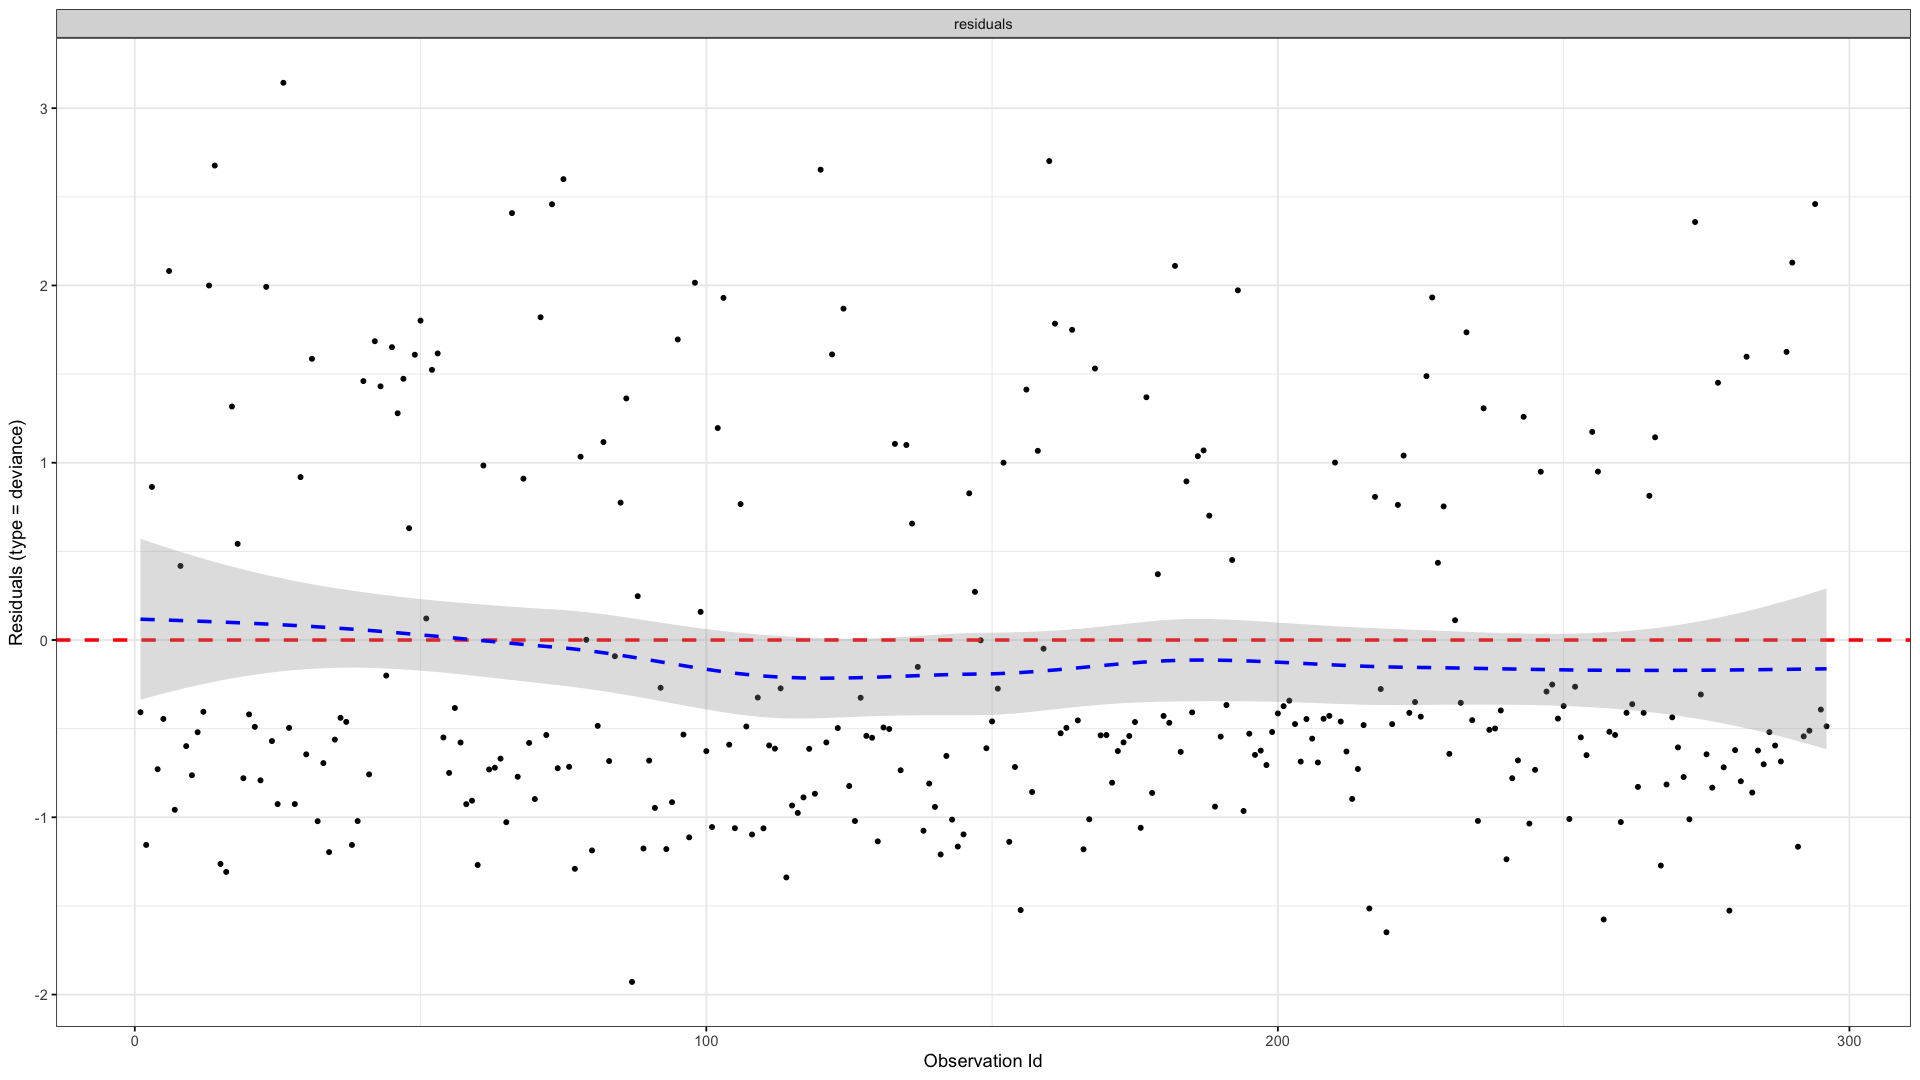

In [77]:
options(repr.plot.width=16, repr.plot.height=9)
ggcoxdiagnostics(best_fit, linear.predictions = FALSE, type = "deviance")

In [85]:
dev_resid <- residuals(best_fit, type = "deviance")
outlier_indices <- which(abs(dev_resid) > 3)
dev_resid[outlier_indices]
df1[outlier_indices, 1:13]

26 
3.143328

,time,event,gender,smoking,diabetes,bp,anaemia,age,ejection.fraction,sodium,creatinine,platelets,cpk
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
26,6,1,1,0,0,0,0,55,38,136,1.1,263358,7861


* The smoother (blue dashed line) hovers close to zero across IDs.
* Confidence band (grey area) is narrow and steady. This suggests no major violations of model assumptions overall.
* However, there are 2 problems
    1. There may be slight asymmetry, with more points below -1 than above +1. These could suggest some mild skew in model fit.
    2. There is a point with a deviance residual > 3. Its information was further investigated. Indeed, this point is unusual. Its continuous variables such as `age` (55), `ejection.fraction` (38) and `creatinine` (1.1) have moderate values. The patient does not have neither higher blood pressure nor anaemia. However, the survival time is very short i.e. only 6 days. The mean survival time is 130 days. The reasons can be data entry error, unmeasured confounders

`geom_smooth()` using formula = 'y ~ x'


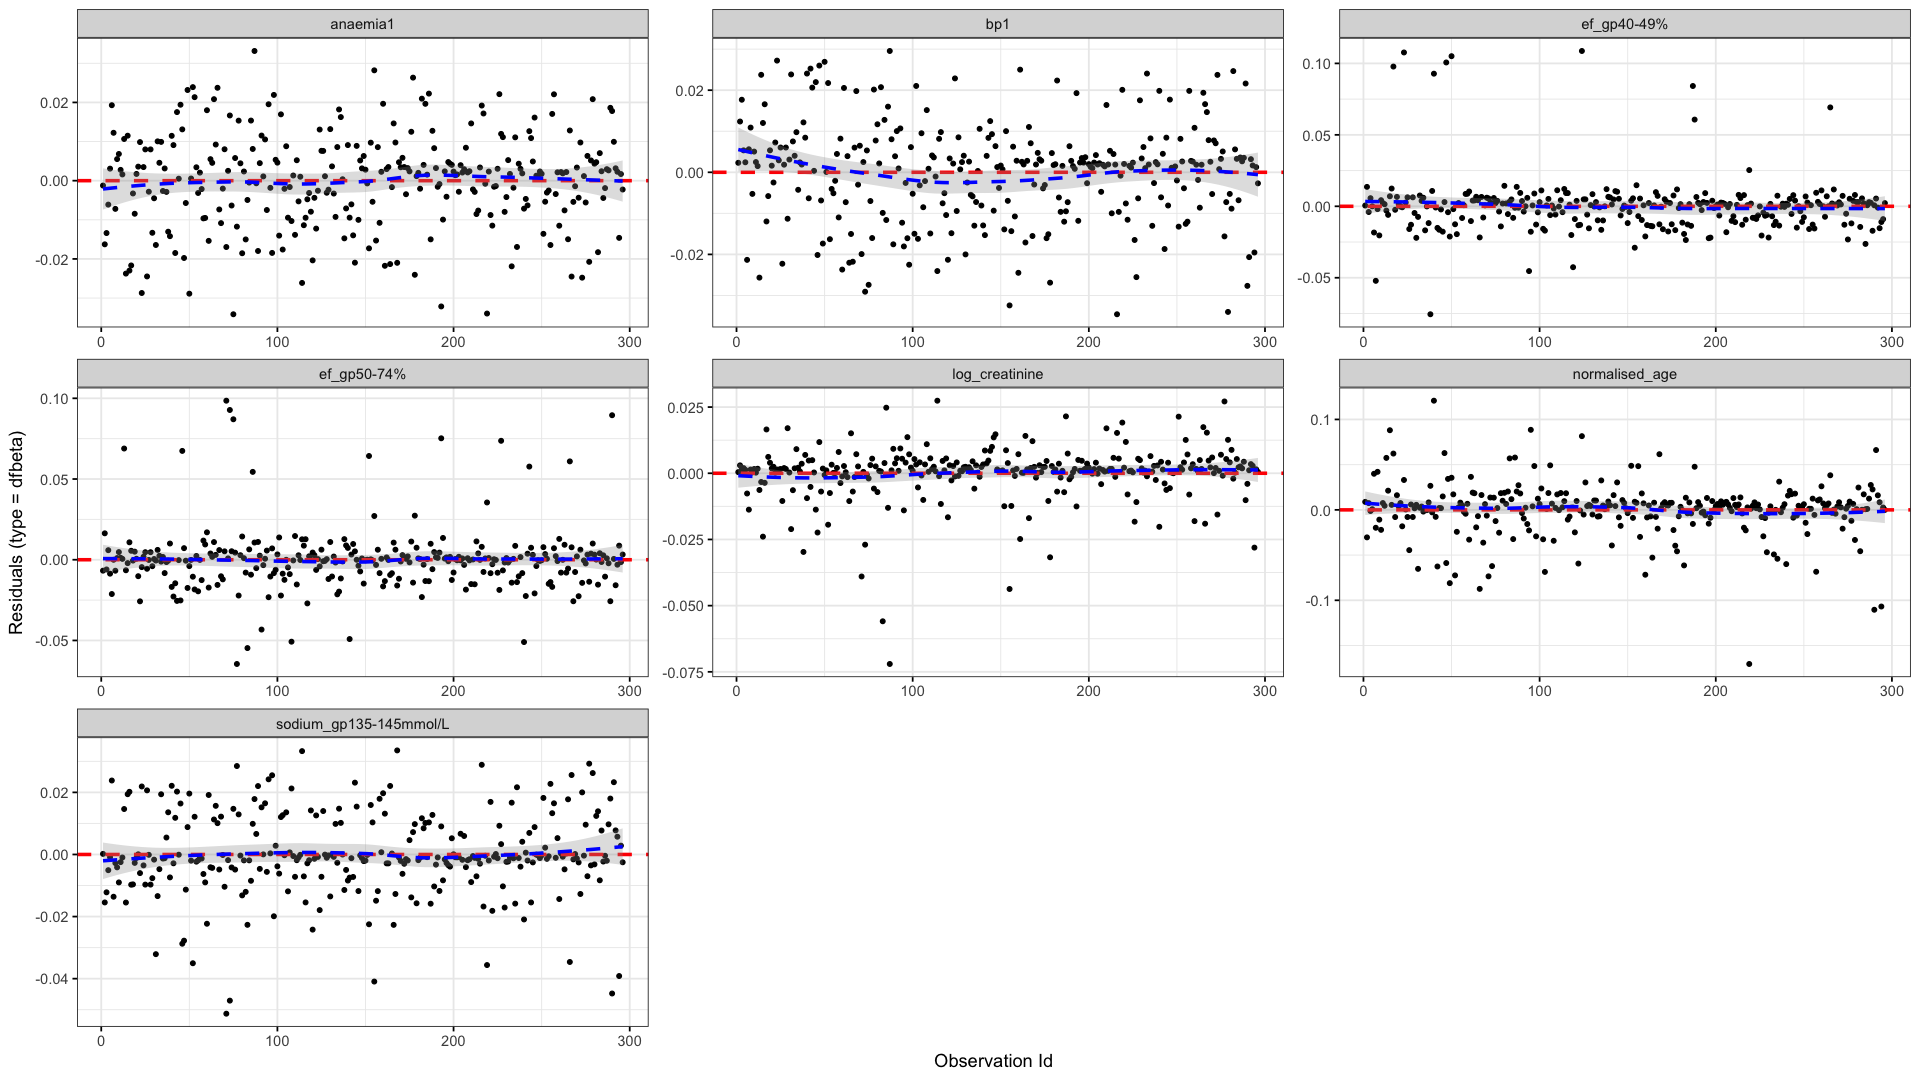

In [66]:
ggcoxdiagnostics(best_fit, type = "dfbeta")

* No extreme influential points are clearly visible for any of the covariates. All dfbeta values appear to hover around 0 with no large deviations.
* The smoothed blue lines remain fairly close to 0, indicating no systemic influence across the observation range.

##### Test non linearity

Warning message:
"arguments formula is deprecated; will be removed in the next version; please use fit instead."


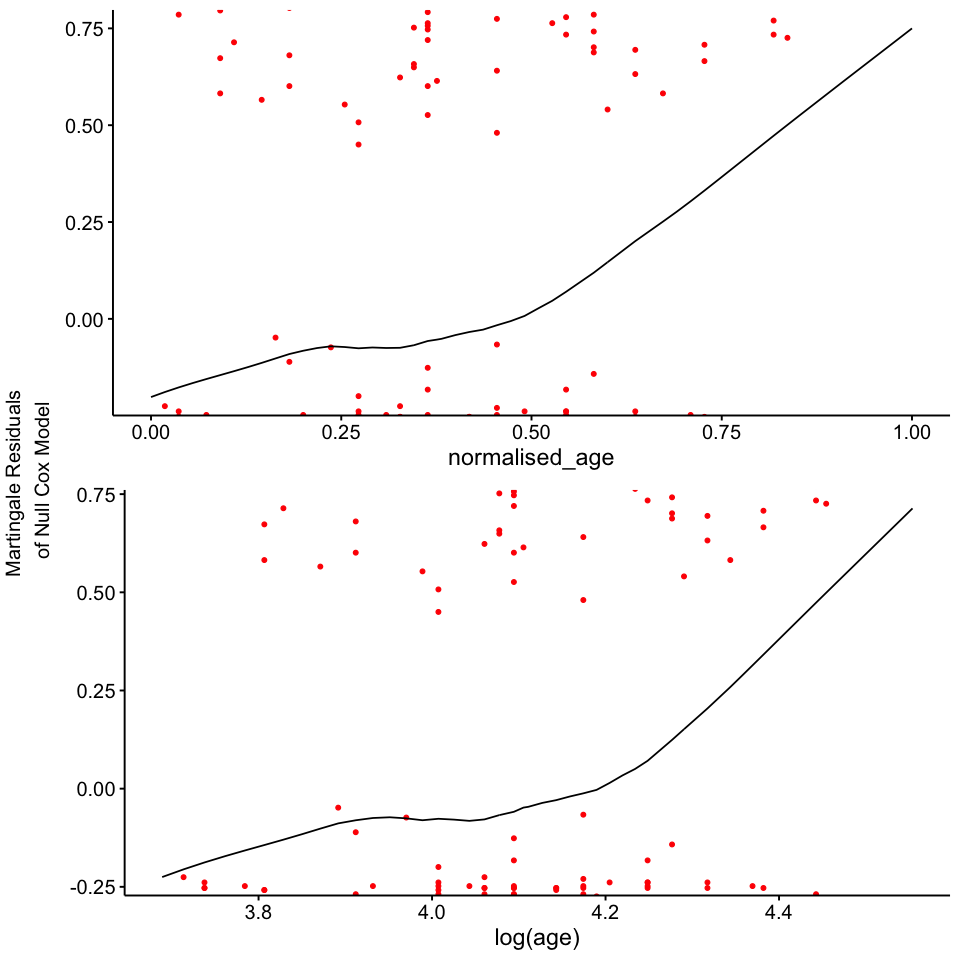

In [98]:
options(repr.plot.width=8, repr.plot.height=8)
ggcoxfunctional(Surv(time, event) ~ normalised_age + log(age), data = df1)

Warning message:
"arguments formula is deprecated; will be removed in the next version; please use fit instead."


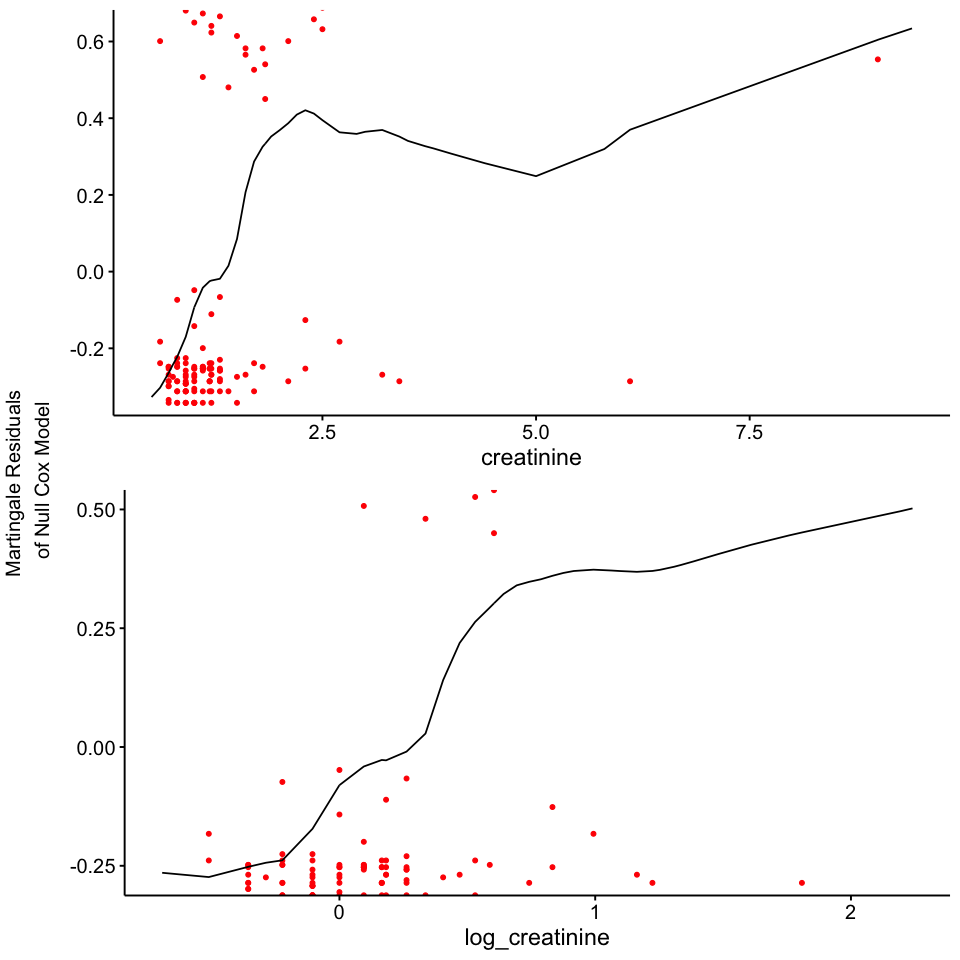

In [106]:
ggcoxfunctional(Surv(time, event) ~ creatinine + log_creatinine, data = df1)

* At the top panel (`creatinine`), the loess curve is not flat and shows a clearly non-linear pattern. This indicates that the relationship between creatinine and the log hazard may not be linear.
* At the bottom panel (`log_creatinine`), the loess curve here is much smoother and more linear compared to the raw creatinine plot. While it still isn’t perfectly flat, it is substantially more linear than the top panel.
* This suggests that `log_creatinine` is a better fit for the Cox model than `creatinine`.
* The spline model was tried

In [114]:
fit_spline <- coxph(formula = Surv(time, event) ~ normalised_age + ef_gp + 
    bp + ns(creatinine, df = 3) + sodium_gp + anaemia, data = df1)

In [116]:
anova(best_fit, fit_spline, test = "LRT")

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-468.1318,NA,NA,NA
2,-467.3335,1.596466,2,0.4501236


* The spline model does not provide a significantly better fit than the simpler model using `log_creatinine`

#### Interpretation

* A one-unit increase in normalised age was associated with a more than sevenfold increase in the hazard of the event (Hazard Ratio [HR] = 7.04, p < 0.001), indicating a strong positive association with risk.
* Participants with an ejection fraction of 40–49% exhibited a 59% reduction in hazard compared to the reference group (<40%) (HR = 0.41, p = 0.013).
* An ejection fraction of 50–74% was associated with a 47% lower hazard relative to the reference group (HR = 0.53, p = 0.042), supporting the protective effect of higher ejection fraction.
* Individuals in the elevated blood pressure group demonstrated a 67% higher hazard in comparison to the reference category (HR = 1.68, p = 0.015), suggesting increased cardiovascular risk.
* Each unit increase in the logarithm of serum creatinine was associated with a 137% increase in hazard (HR = 2.37, p < 0.001), highlighting impaired renal function as a significant risk factor.
* The presence of anaemia was associated with a 55% increase in hazard compared to individuals without anaemia (HR = 1.55, p = 0.038), suggesting a meaningful adverse prognostic impact.

### Reference
* Ahmad, T., Munir, A., Bhatti, S.H., Aftab, M. and Raza, M.A., 2017. _Survival analysis of heart failure patients: A case study._ PLoS ONE, 12(7), p.e0181001. https://doi.org/10.1371/journal.pone.0181001